# CoastSat - Shoreline Data for Grassy

This notebook is used to visualise the CoastSat data. It also shows some of the CoastSat settings used in the Appendix section, with an example of how to visualise the transect locations.

Key Notes:
- Python version 3.8
- Environment: CoastSat_Jul22
- CoastSat: https://github.com/kvos/CoastSat, Version from July 2022.
- Locations: Grassy Beach/Bay, King Island
- GitHub project: https://github.com/james-th94/NaturalShorelineVariability_Grassy

Last updated 30/9/22.

## 1 - Load Packages/Modules 

In [1]:
import pickle # Package to save Python data as a .pkl file
import matplotlib.pyplot as plt 
import pandas as pd
from datetime import datetime, timedelta
import os
import sys
print(sys.executable) # Check Anaconda Environment matches the one listed above

C:\Users\s5245653\Anaconda3\envs\CoastSat_Jul22\python.exe


## 2 - User Inputs

In [2]:
# Set and Check Directory
projectDir = 'C:/Users/s5245653/OneDrive - Griffith University/Projects/NaturalShorelineVariability_Grassy/'
dataDir = 'data/CoastSat/'
outputDir = 'Output/'
inputDir = 'Input/'
plotDir = 'data/Plots/All/Shoreline/'
os.chdir(projectDir + dataDir)
os.getcwd()

# User inputs for Data Analysis
dates = ['1980-01-01', '2022-07-08']
sitename = 'Grassy_' + dates[0] + '_' + dates[1]
shorelineData = projectDir + dataDir + outputDir + sitename + '_shorelines_tidecorrected.csv'
coastsatOutput = projectDir + dataDir + outputDir + sitename + '_output.pkl'

# For Plotting Relative Shoreline Position (RSP)
figSize = [10,6] # figure size in inches
resolution = 600 # dpi
transectOfInterest = 'Transect 1_WEC' 
firstDate = '2016-01-01' # first date to plot
resamplePeriod = '1MS' # change meanLabel below to match
meanLabel = '1-Monthly Mean RSP'
yTitle = 'Relative Shoreline Position (m)' 
xTitle = 'Date (yr)'
labelLoc = 'upper left'
yRange = [-35,35] # metres
summerMonths = [12,1,2] 
winterMonths = [6,7,8]
plotName = projectDir + plotDir + f'{yTitle}_{transectOfInterest}_{firstDate[0:4]}_{resamplePeriod}.jpg'

# For Outputting RSP to csv
csvFile = projectDir + dataDir + outputDir + 'RSP.csv'

## 3 - Processing

C:\Users\s5245653\AppData\Local\Temp\ipykernel_8292\3221281095.py:7: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  dfRSP = dfRSP.truncate(before = firstDate)


-7.791241659153088 5.8777414531458305


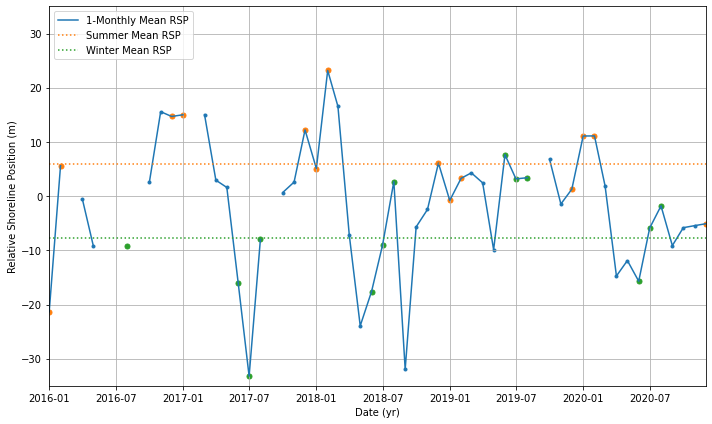

In [3]:
# Get Data with pandas read_csv function, and set index to a datetime index.
df = pd.read_csv(shorelineData, header = 'infer', index_col = 'dates')
df.index = pd.to_datetime(df.index)

# Subtract the median shoreline position to get relative shoreline position (RSP)
dfRSP = df - df.median()
dfRSP = dfRSP.truncate(before = firstDate)
dfRSP_ave = dfRSP.resample(resamplePeriod).mean()
if resamplePeriod == '3MS':
    dfRSP_ave.index = dfRSP_ave.index.shift(freq='1MS') # shift so Jan represents summer, and Jul winter.
summerMean = dfRSP[dfRSP.index.month.isin(summerMonths)][transectOfInterest].mean()
winterMean = dfRSP[dfRSP.index.month.isin(winterMonths)][transectOfInterest].mean()

# Plot Figure
fig, ax = plt.subplots(figsize = figSize, tight_layout=True)
ax.plot(dfRSP_ave[transectOfInterest], color = 'C0', label = meanLabel)
for i in range(len(dfRSP_ave)):
    if dfRSP_ave.index[i].month in summerMonths:
        ax.scatter(x = dfRSP_ave.index[i], y = dfRSP_ave[transectOfInterest][i], 
                   s = figSize[0] ** 2, color = 'C1', marker = '.')
    elif dfRSP_ave.index[i].month in winterMonths:
        ax.scatter(x = dfRSP_ave.index[i], y = dfRSP_ave[transectOfInterest][i], 
                   s = figSize[0] ** 2, color = 'C2', marker = '.')
    else:
        ax.scatter(x = dfRSP_ave.index[i], y = dfRSP_ave[transectOfInterest][i], 
                   color = 'C0', marker = '.')
ax.axhline(summerMean, color = 'C1', label = 'Summer Mean RSP', ls = ':')
ax.axhline(winterMean, color = 'C2', label = 'Winter Mean RSP', ls = ':')

ax.set_xlabel(xTitle)
ax.set_ylabel(yTitle)
ax.grid()
plt.ylim(yRange)
plt.legend(loc = labelLoc)
plt.autoscale(enable=True, axis='x', tight=True)

# Save plot to file "plotName"
#plt.savefig(plotName, dpi = resolution)
print(winterMean,summerMean)

In [ ]:
# Save Relative Shoreline Position data for further analysis

# Change column names
dfTemp = dfRSP.iloc[:, ::-1]
dfTemp.columns = range(0, 25 * 50, 50)
dfTemp.to_csv(csvFile)

In [ ]:
# For other CoastSat analysis... 
# Create output variable from .pkl file
with open(coastsatOutput, 'rb') as f:
    output = pickle.load(f)

## Appendix

### Appendix 1 - CoastSat Settings

In [ ]:
# CoastSat Settings

## CoastSat package details can be found at https://github.com/kvos/CoastSat. 
## Version 1 of CoastSat was used, before Landsat 9 data was added (Version 2.0).

# CoastSat Version 1
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_transects

# Import further packages
# # Scientific Modules
import numpy as np
# 
from matplotlib import gridspec
plt.ion()
# Geospatial Modules
from shapely.geometry import LineString
import geopandas as gpd
# Other Modules
import warnings
warnings.filterwarnings("ignore")


## Spatial Range
## Choose the latitude/longitude boundaries of the CoastSat domain, then 
## convert to be the smallest rectangle with sides parallel to the coordinate axes
polygon = [[[144.046,-40.0645],
            [144.061,-40.0645],
            [144.061,-40.0725],
            [144.046,-40.0725]]]
polygon = SDS_tools.smallest_rectangle(polygon)

## Date Range
## Choose the start date and end date for Google Earth Engine satellite retrieval.
dates = ['1980-01-01', '2022-07-08']

## Satellite Missions
## Choose the satellites you want to retrieve images for from the list; [L5, L7, L8, S2].
## A landsat collection variable is also required - see CoastSat GitHub for details. 
sat_list = ['S2']
collection = 'C01'

## Data Location
## Set the location of the CoastSat data using a sitename. 
## Recommend using a sitename which varies with inputs (e.g. date range). 
## The filepath will be where the data is stored.
sitename = 'Grassy_' + dates[0] + '_' + dates[1]
filepath = os.path.join(os.getcwd(), 'data')

## Save Inputs
inputs = {'polygon': polygon, 'dates': dates, 'sat_list': sat_list, 'sitename': sitename, 'filepath':filepath,
          'landsat_collection': collection}

## Settings for the shoreline extraction
settings = { 
    # general parameters:
    'cloud_thresh': 0.5,        # threshold on maximum cloud cover
    'output_epsg': 3857,        # epsg code of spatial reference system desired for the output   
    # quality control:
    'check_detection': True,    # if True, shows each shoreline detection to the user for validation
    'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
    'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
    # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
    'min_beach_area': 6000,     # minimum area (in metres^2) for an object to be labelled as a beach
    'buffer_size': 150,         # radius (in metres) of the buffer around sandy pixels considered in the shoreline detection
    'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
    'cloud_mask_issue': False,  # switch this parameter to True if sand pixels are masked (in black) on many images  
    'sand_color': 'default',    # 'default', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
    # add the inputs defined previously
    'inputs': inputs,
    'along_dist': 25,
}

beach_slope = 0.045

### Appendix 2 - Transects

This section creates transect data from the shoreline data, useful for assessing shoreline change with time at specific locations along the beach.

See the CoastSat github for options on how to define transect locations. Here, QGIS was used to manually create transect locations every 50 m along the beach.

Transects are plotted to check the locations are correct, and their origin is at the landward extend. Again, for figures, it is better to use GIS software to plot transect locations over a map.

In [ ]:
geojson_file = projectDir + dataDir + inputDir + 'Transects_Grassy.geojson'
transects = SDS_tools.transects_from_geojson(geojson_file)

fig = plt.figure(figsize=figSize, tight_layout=True)
plt.axis('equal')

plt.xlabel('Eastings')
plt.ylabel('Northings')
plt.grid(linestyle=':', color='0.5')

for i in range(len(output['shorelines'])):
     sl = output['shorelines'][i]
     date = output['dates'][i]
     plt.plot(sl[:,0], sl[:,1], '.', label=date.strftime('%d-%m-%Y'))
for i,key in enumerate(list(transects.keys())):
    plt.plot(transects[key][0,0],transects[key][0,1], 'bo', ms=5)
    plt.plot(transects[key][:,0],transects[key][:,1],'k-',lw=1)
    plt.text(transects[key][0,0]-100, transects[key][0,1]+100, key,
                va='center', ha='right', bbox=dict(boxstyle="square", ec='k',fc='w'))

# THE END